#### The simplest formulation of policy gradient with real-time rendering

You can find more details about implementation [here](https://spinningup.openai.com/en/latest/user/introduction.html).

In [1]:
!apt-get install -y xvfb \
                    python-opengl > /dev/null
!pip install gym \
             pyvirtualdisplay > /dev/null

In [1]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

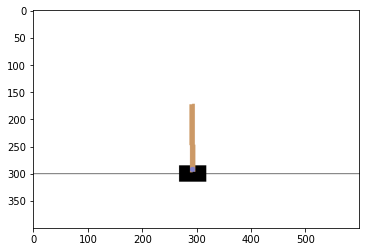

epoch:   0 	 loss: 17.152 	 return: 20.941 	 ep_len: 20.941
epoch:   1 	 loss: 18.211 	 return: 22.031 	 ep_len: 22.031
epoch:   2 	 loss: 22.243 	 return: 25.280 	 ep_len: 25.280
epoch:   3 	 loss: 24.347 	 return: 27.348 	 ep_len: 27.348
epoch:   4 	 loss: 24.704 	 return: 28.129 	 ep_len: 28.129
epoch:   5 	 loss: 30.823 	 return: 32.791 	 ep_len: 32.791
epoch:   6 	 loss: 29.093 	 return: 34.322 	 ep_len: 34.322
epoch:   7 	 loss: 31.899 	 return: 38.527 	 ep_len: 38.527
epoch:   8 	 loss: 38.864 	 return: 45.582 	 ep_len: 45.582
epoch:   9 	 loss: 40.967 	 return: 47.217 	 ep_len: 47.217
epoch:  10 	 loss: 46.884 	 return: 57.023 	 ep_len: 57.023
epoch:  11 	 loss: 42.733 	 return: 53.660 	 ep_len: 53.660
epoch:  12 	 loss: 42.242 	 return: 54.467 	 ep_len: 54.467
epoch:  13 	 loss: 51.583 	 return: 67.581 	 ep_len: 67.581


In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import numpy as np
import gym
from gym.spaces import Discrete, Box

from IPython import display as ipythondisplay
import matplotlib.pyplot as plt

def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
      act = activation if j < len(sizes)-2 else output_activation
      layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def train(env_name='CartPole-v0', hidden_sizes=[32], lr=1e-2, 
          epochs=50, batch_size=5000, render=False):

    # make environment, check spaces, get obs / act dims
    env = gym.make(env_name)
    assert isinstance(env.observation_space, Box), \
        "This example only works for envs with continuous state spaces."
    assert isinstance(env.action_space, Discrete), \
        "This example only works for envs with discrete action spaces."

    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n

    # make core of policy network
    logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts])

    # make function to compute action distribution
    def get_policy(obs):
      logits = logits_net(obs)
      return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
      return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
      logp = get_policy(obs).log_prob(act)
      return -(logp * weights).mean()

    # make optimizer
    optimizer = Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
      # make some empty lists for logging.
      batch_obs = []          # for observations
      batch_acts = []         # for actions
      batch_weights = []      # for R(tau) weighting in policy gradient
      batch_rets = []         # for measuring episode returns
      batch_lens = []         # for measuring episode lengths

      # reset episode-specific variables
      obs = env.reset()       # first obs comes from starting distribution
      done = False            # signal from environment that episode is over
      ep_rews = []            # list for rewards accrued throughout ep

      # render first episode of each epoch
      finished_rendering_this_epoch = False

      # collect experience by acting in the environment with current policy
      while True:

        # rendering
        if (not finished_rendering_this_epoch) and render:
          screen = env.render(mode='rgb_array')

          plt.imshow(screen)
          ipythondisplay.clear_output(wait=True)
          ipythondisplay.display(plt.gcf())

        # print epoch infomation
        if (not finished_rendering_this_epoch) and epoch_logs:
          print('epoch logs\n')
          for epoch_info in epoch_logs:
            print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (epoch_info['epoch'], epoch_info['batch_loss'], np.mean(epoch_info['batch_rets']), np.mean(epoch_info['batch_lens'])))

        # save obs
        batch_obs.append(obs.copy())

        # act in the environment
        act = get_action(torch.as_tensor(obs, dtype=torch.float32))
        obs, rew, done, _ = env.step(act)

        # save action, reward
        batch_acts.append(act)
        ep_rews.append(rew)

        if done:
          # if episode is over, record info about episode
          ep_ret, ep_len = sum(ep_rews), len(ep_rews)
          batch_rets.append(ep_ret)
          batch_lens.append(ep_len)

          # the weight for each logprob(a|s) is R(tau)
          batch_weights += [ep_ret] * ep_len

          # reset episode-specific variables
          obs, done, ep_rews = env.reset(), False, []

          # won't render again this epoch
          finished_rendering_this_epoch = True

          # end experience loop if we have enough of it
          if len(batch_obs) > batch_size:
            break

      # take a single policy gradient update step
      optimizer.zero_grad()
      batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
                                act=torch.as_tensor(batch_acts, dtype=torch.int32),
                                weights=torch.as_tensor(batch_weights, dtype=torch.float32)
                                )
      batch_loss.backward()
      optimizer.step()
      return batch_loss, batch_rets, batch_lens

    epoch_logs = []

    # training loop
    for i in range(epochs):
        batch_loss, batch_rets, batch_lens = train_one_epoch()
        epoch_info = {"epoch": i, "batch_loss": batch_loss, "batch_rets": batch_rets, "batch_lens": batch_lens}
        epoch_logs.append(epoch_info)

print('\nUsing simplest formulation of policy gradient.\n')
train(render=True)

ipythondisplay.clear_output(wait=True)
